In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
%matplotlib inline

from collections import namedtuple
from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import sys
sys.path.append('/home/ryohayama/python_current/BasicFeatureAnalysis')

import feature as F
import feature_collection as FC
import ps.joint_probability as psjp

In [3]:
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

all_fs = train.columns[2:]

binary_fs = sorted([f for f in all_fs if '_bin' in f])

categorical_fs = sorted([f for f in all_fs if '_cat' in f])

other_fs = sorted([f for f in all_fs
                if f not in binary_fs
                if f not in categorical_fs])

target = train.target

In [4]:
cont_fs = ['ps_calc_05', 'ps_calc_07', 'ps_calc_10', 'ps_calc_12', 
           'ps_calc_13', 'ps_calc_14', 'ps_car_11', 'ps_car_12', 
           'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01', 
           'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 
           'ps_reg_02', 'ps_reg_03']

In [5]:
conts_train = train[cont_fs]
conts_test = test[cont_fs]

# Check for differences between train and test

In [40]:
# train vs test
df = pd.DataFrame(index=sorted(conts_train.columns))
identical_fs = []
nonidentical_fs = []
for i, f in enumerate(conts_train.columns):
    uniques_train = conts_train[f].unique()
    uniques_test = conts_test[f].unique()
    num_uniques_train = len(uniques_train)
    num_uniques_test = len(uniques_test)
    comparison = (num_uniques_train == num_uniques_test)
    if comparison:
        identical_fs.append(f)
    else:
        nonidentical_fs.append(f)
        
    df.loc[f, 'num_uniques_train'] = num_uniques_train
    df.loc[f, 'num_uniques_test'] = num_uniques_test
    df.loc[f, 'identical_space'] = int(comparison)
    #df.loc[f, 'uniques_train'] = tuple(uniques_train)
    #df.loc[f, 'uniques_test'] = tuple(uniques_test)
    
print('====================================')
print('Features with identical space:')
print(identical_fs)
print('Features with nonidentical space:')
print(nonidentical_fs)

Features with identical space:
['ps_calc_05', 'ps_calc_07', 'ps_calc_10', 'ps_calc_12', 'ps_car_11', 'ps_car_15', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02']
Features with nonidentical space:
['ps_calc_13', 'ps_calc_14', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_reg_03']


## features whose value space is identical in train and test

In [46]:
df[df.identical_space == 1]

,num_uniques_train,num_uniques_test,identical_space
ps_calc_05,7.0,7.0,1.0
ps_calc_07,10.0,10.0,1.0
ps_calc_10,26.0,26.0,1.0
ps_calc_12,11.0,11.0,1.0
ps_car_11,5.0,5.0,1.0
ps_car_15,15.0,15.0,1.0
ps_ind_01,8.0,8.0,1.0
ps_ind_03,12.0,12.0,1.0
ps_ind_14,5.0,5.0,1.0
ps_ind_15,14.0,14.0,1.0


In [52]:
# identical space ones
for i, f in enumerate(identical_fs):
    uniques = conts_train[f].unique()
    num_uniques = len(uniques)
    print('%s, %d unique vals:\n' % (f, num_uniques), uniques)

ps_calc_05, 7 unique vals:
 [1 2 4 3 0 5 6]
ps_calc_07, 10 unique vals:
 [1 5 3 2 4 6 0 7 8 9]
ps_calc_10, 26 unique vals:
 [ 5  7  2 12  8 10 13 11  9 18  4 15  6 14 16  3  1 17  0 21 19 20 22 23 25
 24]
ps_calc_12, 11 unique vals:
 [ 1  2  0  5  3  4  6  7  8  9 10]
ps_car_11, 5 unique vals:
 [ 2  3  1  0 -1]
ps_car_15, 15 unique vals:
 [ 3.60555128  2.44948974  3.31662479  2.          3.          3.16227766
  2.82842712  3.74165739  2.64575131  0.          1.41421356  3.46410162
  1.73205081  2.23606798  1.        ]
ps_ind_01, 8 unique vals:
 [2 1 5 0 4 3 6 7]
ps_ind_03, 12 unique vals:
 [ 5  7  9  2  0  4  3  1 11  6  8 10]
ps_ind_14, 5 unique vals:
 [0 1 2 3 4]
ps_ind_15, 14 unique vals:
 [11  3 12  8  9  6 13  4 10  5  7  2  0  1]
ps_reg_01, 10 unique vals:
 [ 0.7  0.8  0.   0.9  0.6  0.5  0.4  0.3  0.2  0.1]
ps_reg_02, 19 unique vals:
 [ 0.2  0.4  0.   0.6  1.8  0.1  0.7  1.4  0.9  0.3  0.5  0.8  1.   1.3  1.6
  1.5  1.2  1.1  1.7]


<b>These guys can be treated as categoricals (i.e. digital space features), so CategoricalCollection and joint_probability functions can be applied.</b>

## features whose value space is not identical in train and test

In [47]:
df[df.identical_space == 0]

,num_uniques_train,num_uniques_test,identical_space
ps_calc_13,14.0,16.0,0.0
ps_calc_14,24.0,25.0,0.0
ps_car_12,184.0,201.0,0.0
ps_car_13,70482.0,83769.0,0.0
ps_car_14,850.0,885.0,0.0
ps_reg_03,5013.0,5046.0,0.0


In [62]:
# non-identical space ones with small space
nonidentical_fs_sub1 = ['ps_calc_13', 'ps_calc_14']
for i, f in enumerate(nonidentical_fs_sub1):
    uniques_train = conts_train[f].unique()
    uniques_test = conts_test[f].unique()
    num_uniques_train = len(uniques_train)
    num_uniques_test = len(uniques_test)
    print('===== %s (%d vs %d unique vals) =====:' % (f, num_uniques_train, num_uniques_test))
    print('train:', sorted(uniques_train))
    print('test :', sorted(uniques_test))

===== ps_calc_13 (14 vs 16 unique vals) =====:
train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
test : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
===== ps_calc_14 (24 vs 25 unique vals) =====:
train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
test : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 28]


In [65]:
test[(test.ps_calc_13 == 14) | (test.ps_calc_13 == 15) | (test.ps_calc_14 == 28)]

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
23022,38244,5,1,2,0,0,0,0,1,0,...,7,2,15,5,0,1,0,0,0,1
39496,65734,3,2,1,0,0,0,1,0,0,...,9,1,5,28,0,1,0,1,0,1
654922,1091897,1,1,6,0,0,1,0,0,0,...,3,0,14,9,1,0,0,1,0,0
826079,1377031,0,1,0,0,0,0,0,1,0,...,5,2,14,10,0,0,0,0,0,0


<b>There are so few with those extra features so maybe they could be replaced with 13 for calc_13 and 23 for calc_15 (considering they're ordinals)</b>

(array([  2.26374717e-03,   2.51915555e-01,   1.49632434e+00,
          1.18160705e+00,   6.76565679e-01,   4.59584572e-01,
          2.88925626e-01,   1.49156483e-01,   5.97855002e-02,
          1.21402065e-02,   4.66545124e-03,   1.10365513e-03,
          4.89119888e-04,   1.12873820e-04,   1.25415356e-05,
          5.01661424e-05,   0.00000000e+00,   2.50830712e-05,
          2.50830712e-05,   6.27076780e-06]),
 array([ 0.06123724,  0.27935122,  0.49746519,  0.71557916,  0.93369313,
         1.15180711,  1.36992108,  1.58803505,  1.80614903,  2.024263  ,
         2.24237697,  2.46049094,  2.67860492,  2.89671889,  3.11483286,
         3.33294684,  3.55106081,  3.76917478,  3.98728875,  4.20540273,
         4.4235167 ]),
 <a list of 20 Patch objects>)

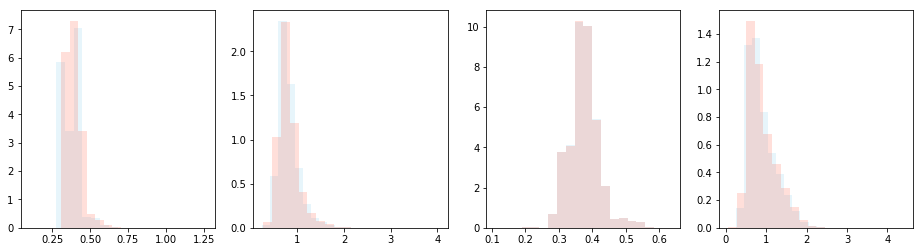

In [87]:
# non-identical space ones with large feature space
bins=20
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.hist(train.ps_car_12.replace({-1:np.NaN}).dropna(), bins=bins, normed=True, color='skyblue', alpha=0.2)
ax1.hist(test.ps_car_12.replace({-1:np.NaN}).dropna(), bins=bins, normed=True, color='tomato', alpha=0.2)

ax2.hist(train.ps_car_13.replace({-1:np.NaN}).dropna(), bins=bins, normed=True, color='skyblue', alpha=0.2)
ax2.hist(test.ps_car_13.replace({-1:np.NaN}).dropna(), bins=bins, normed=True, color='tomato', alpha=0.2)

ax3.hist(train.ps_car_14.replace({-1:np.NaN}).dropna(), bins=bins, normed=True, color='skyblue', alpha=0.2)
ax3.hist(test.ps_car_14.replace({-1:np.NaN}).dropna(), bins=bins, normed=True, color='tomato', alpha=0.2)

ax4.hist(train.ps_reg_03.replace({-1:np.NaN}).dropna(), bins=bins, normed=True, color='skyblue', alpha=0.2)
ax4.hist(test.ps_reg_03.replace({-1:np.NaN}).dropna(), bins=bins, normed=True, color='tomato', alpha=0.2)

I guess the distributions of these features are almost identical between train and test sets.

# Digital Ordinal Features

In [89]:
digital_cont_fs = identical_fs + ['ps_calc_13', 'ps_calc_14']
digitals = train[digital_cont_fs]
digital_cont_fs

['ps_calc_05',
 'ps_calc_07',
 'ps_calc_10',
 'ps_calc_12',
 'ps_car_11',
 'ps_car_15',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_calc_13',
 'ps_calc_14']

In [90]:
digital_collection = FC.CategoricalFeatureCollection(digitals, target=target)

In [91]:
digital_probas = digital_collection.convert2CondProba(target_class=1)

In [93]:
digital_probas.describe()

,ps_calc_05,ps_calc_07,ps_calc_10,ps_calc_12,ps_car_11,ps_car_15,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448,0.036448
std,0.000641,0.000822,0.001190,0.000479,0.003885,0.005908,0.003879,0.006241,0.001498,0.004443,0.005176,0.007312,0.000709,0.000941
min,0.036009,0.031079,0.000000,0.000000,0.000000,0.022897,0.033221,0.029559,0.036301,0.030480,0.023824,0.024296,0.022727,0.000000
25%,0.036194,0.035964,0.035750,0.036393,0.036069,0.032108,0.033221,0.030340,0.036301,0.030925,0.034498,0.033757,0.036316,0.036013
50%,0.036404,0.036384,0.035963,0.036393,0.036069,0.038044,0.033629,0.037136,0.036301,0.038801,0.038555,0.033775,0.036364,0.036197
75%,0.036642,0.036849,0.037163,0.036759,0.038584,0.040082,0.040316,0.040527,0.036301,0.039350,0.041134,0.042527,0.036675,0.037000
max,0.053763,0.086957,0.047619,0.045455,0.047069,0.044395,0.045132,0.062846,0.200000,0.046053,0.041134,0.062909,0.250000,0.061069


In [94]:
feature_pair_list = list(combinations(digital_cont_fs, 2))
len(feature_pair_list)

91

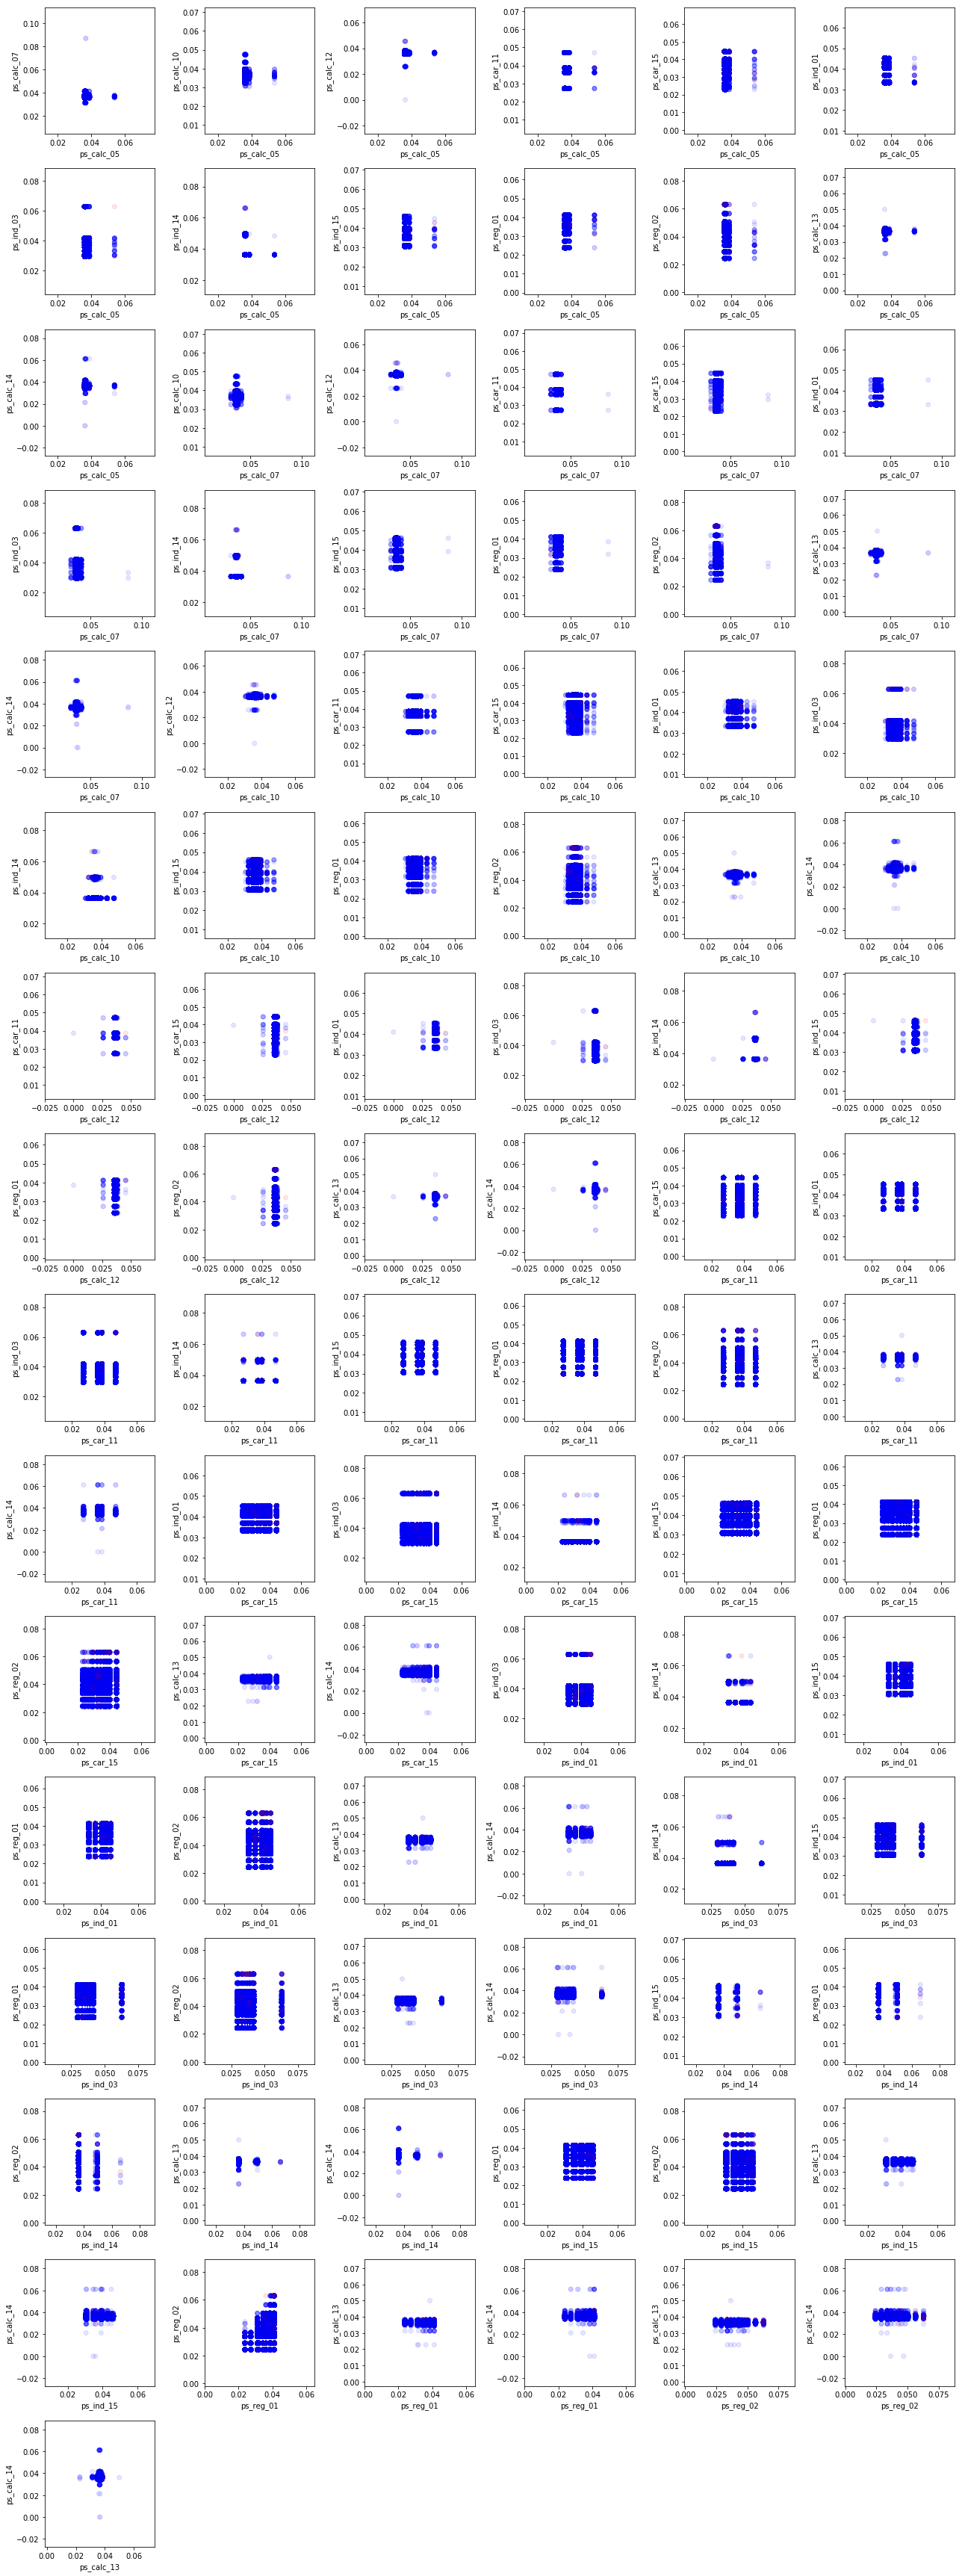

In [97]:
num_plot= 50000
y = np.array(target)
fig = plt.figure(figsize=(18, 48))
for i, pair in enumerate(feature_pair_list):
    x0 = np.array(digital_probas[pair[0]])
    x1 = np.array(digital_probas[pair[1]])
    
    ax = fig.add_subplot(16, 6, i+1)
    ax.scatter(x0[:num_plot], x1[:num_plot], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()

In [98]:
pca = PCA()
Xpca = pca.fit_transform(np.array(digital_probas))

pca_labels = [('component_' + str(i)) for i in range(Xpca.shape[1])]
conts_pca = pd.DataFrame(Xpca, columns=pca_labels)

In [99]:
pca_pair_list = list(combinations(conts_pca.columns, 2))
len(pca_pair_list)

91

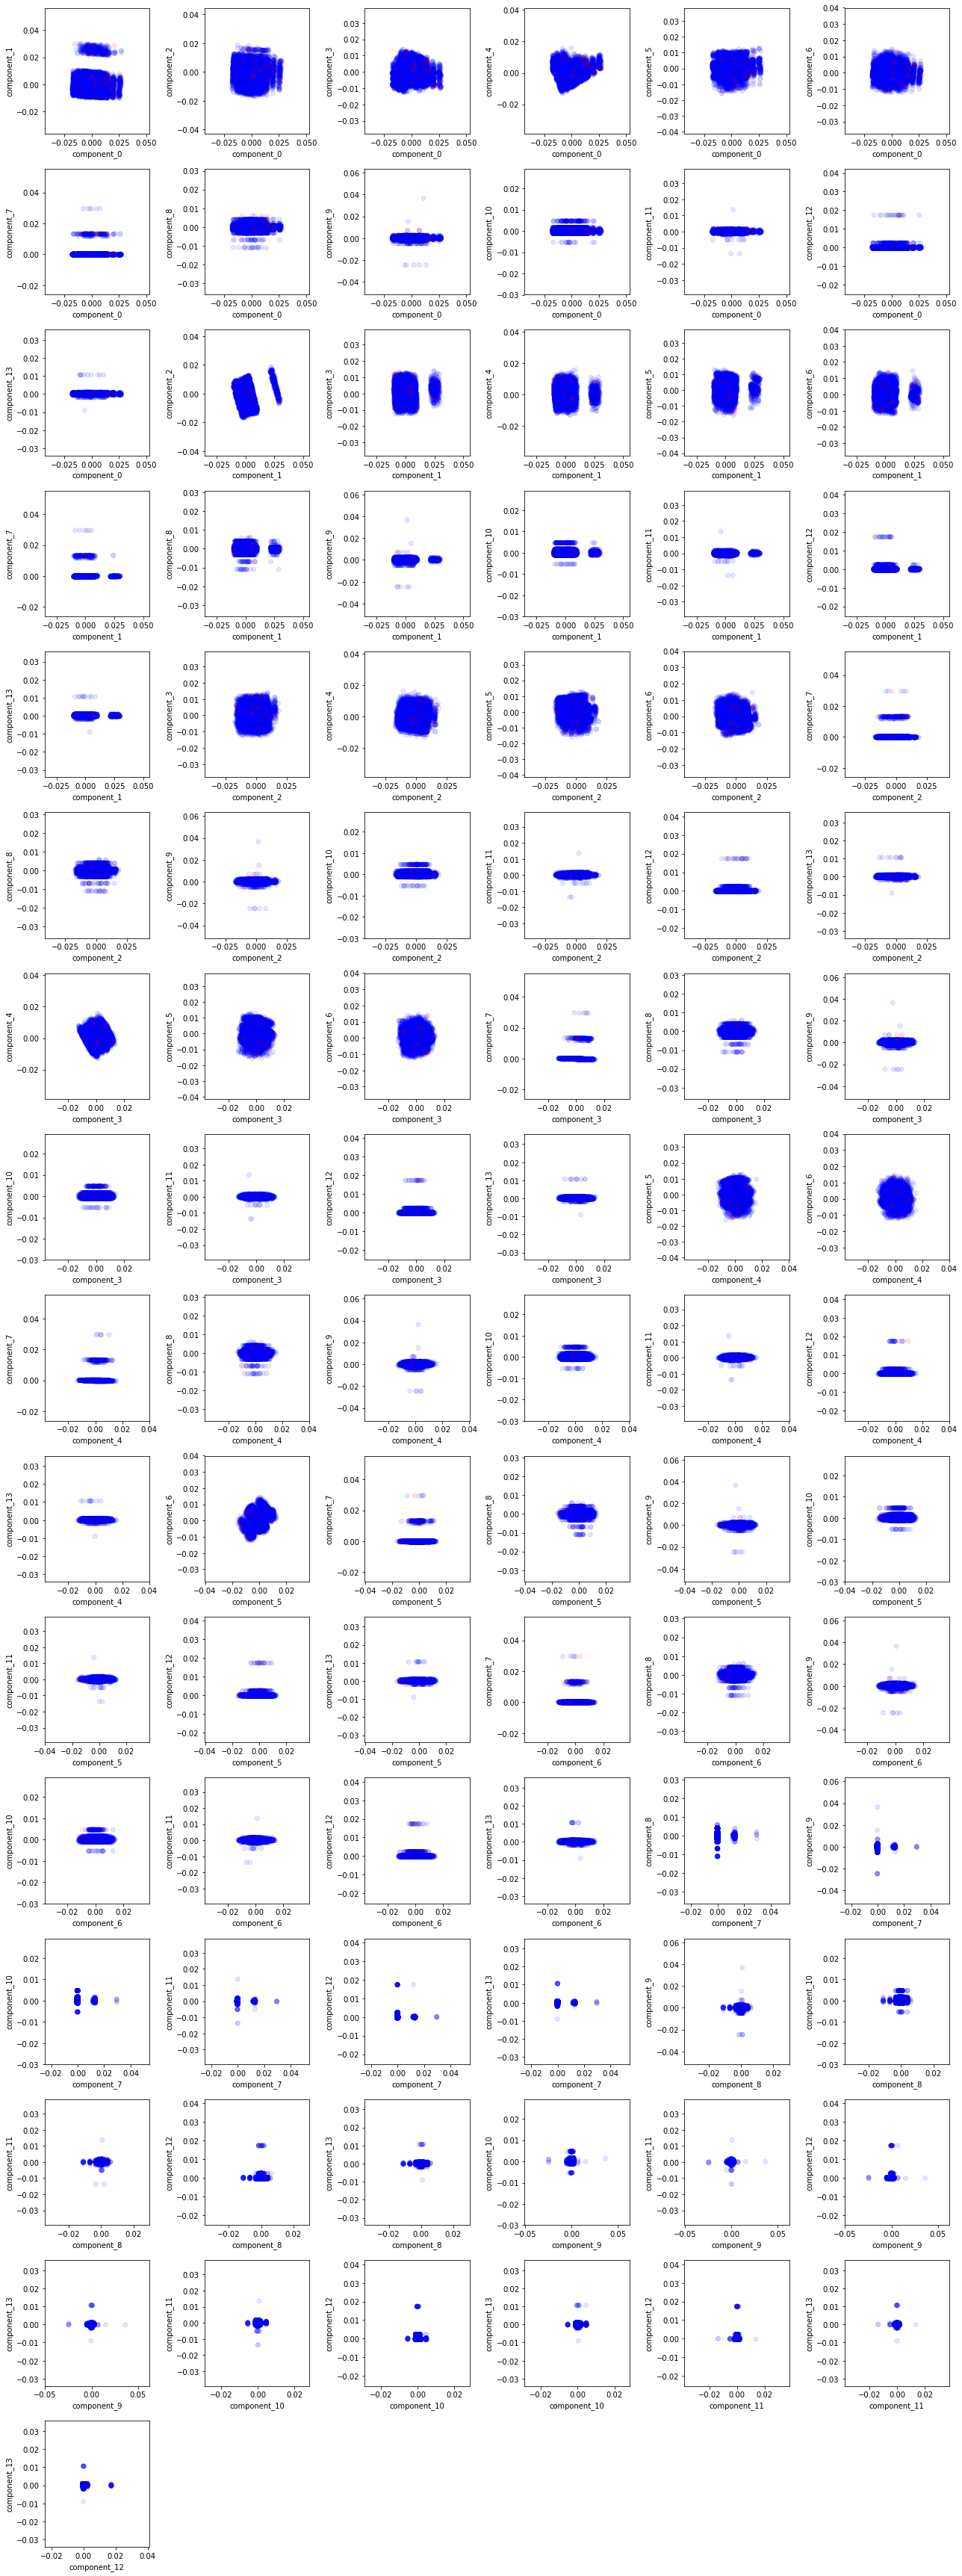

In [100]:
num_plot= 20000
fig = plt.figure(figsize=(18, 48))
for i, pair in enumerate(pca_pair_list):
    x0 = np.array(conts_pca[pair[0]])
    x1 = np.array(conts_pca[pair[1]])
    
    ax = fig.add_subplot(16, 6, i+1)
    ax.scatter(x0[:num_plot], x1[:num_plot], c=y[:num_plot], cmap=cm.bwr, alpha=0.1)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()